# Introduction

The objective of this project is to apply machine learning on a Kaggle dataset called Titanic : https://www.kaggle.com/c/titanic

This dataset is split into 2 csv files: 
    1. train.csv
    2. test.csv

The idea is to predict who died on test.csv file based on train.csv file.

# Import Python Libraries

In [1]:
# Import libraries for data exploration
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Import data

In [2]:
# Create datasets with our 2 csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dfs = [test,train]

for df in dfs:
    print(df.shape)

(418, 11)
(891, 12)


In [3]:
# Preview Data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Exploration

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Identify Missing Data

In [5]:
train.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We notice that we have missing data for the following columns:

    Age
    Cabin
    Embarked

In [7]:
# Some values could be wrong as well, let's check some columns
for i in train.columns:
    if i in ['Survived','Pclass','Sex','SibSp','Parch','Embarked']:
        print(train[i].unique())

[0 1]
[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[1 0 3 4 2 5 8]
[0 1 2 5 3 4 6]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39; nan]


# Dealing with Missing Data

## Let's fill age

In [8]:
train_age = train[train['Age'].notna()]
table = pd.pivot_table(train_age, values='Age', index=['Pclass', 'Sex'], aggfunc=np.average)
table

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [9]:
for df in dfs:
    df['Age'] = df['Age'].replace(np.nan, '0', regex=True)
    df['Age'] = df['Age'].astype(int)
    df.loc[(df['Pclass'] == 1) & (df['Sex'] == 0) & (df['Age'] == 0), 'Age'] = 41
    df.loc[(df['Pclass'] == 1) & (df['Sex'] == 1) & (df['Age'] == 0), 'Age'] = 35
    df.loc[(df['Pclass'] == 2) & (df['Sex'] == 0) & (df['Age'] == 0), 'Age'] = 31
    df.loc[(df['Pclass'] == 2) & (df['Sex'] == 1) & (df['Age'] == 0), 'Age'] = 29
    df.loc[(df['Pclass'] == 3) & (df['Sex'] == 0) & (df['Age'] == 0), 'Age'] = 27
    df.loc[(df['Pclass'] == 3) & (df['Sex'] == 1) & (df['Age'] == 0), 'Age'] = 22
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,23.783389,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,17.597344,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,6.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
for df in dfs:
    df.drop(columns = ['Cabin'],inplace = True)

train.dropna(inplace = True)
test.fillna(0,inplace = True)

len(train)

889

# Format Data: X and y

In [11]:
for df in dfs:
    df.drop(columns = ["Ticket","Name"], inplace = True)

X = train.drop(columns = ["Survived","PassengerId"])
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22,1,0,7.2500,S
1,1,female,38,1,0,71.2833,C
2,3,female,26,0,0,7.9250,S
3,1,female,35,1,0,53.1000,S
4,3,male,35,0,0,8.0500,S


In [12]:
Y = train["Survived"]
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Format the Data: Scaling

In [13]:
X.dtypes

Pclass        int64
Sex          object
Age           int32
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [14]:
for i in X.columns:
    if i in ['Pclass','Sex','SibSp','Parch','Embarked']:
        print(X[i].unique())

[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[1 0 3 4 2 5 8]
[0 1 2 5 3 4 6]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39;]


In [15]:
X = pd.get_dummies(X,columns=['Sex','Embarked'])
test = pd.get_dummies(test,columns=['Sex','Embarked'])
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22,1,0,7.2500,0,1,0,0,1
1,1,38,1,0,71.2833,1,0,1,0,0
2,3,26,0,0,7.9250,1,0,0,0,1
3,1,35,1,0,53.1000,1,0,0,0,1
4,3,35,0,0,8.0500,0,1,0,0,1


In [16]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34,0,0,7.8292,0,1,0,1,0
1,893,3,47,1,0,7.0000,1,0,0,0,1
2,894,2,62,0,0,9.6875,0,1,0,1,0
3,895,3,27,0,0,8.6625,0,1,0,0,1
4,896,3,22,1,1,12.2875,1,0,0,0,1


# Build a Classification Tree

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
random_state_number = 3
clf_dt = DecisionTreeClassifier(random_state=random_state_number)
clf_dt = clf_dt.fit(X_train,Y_train)

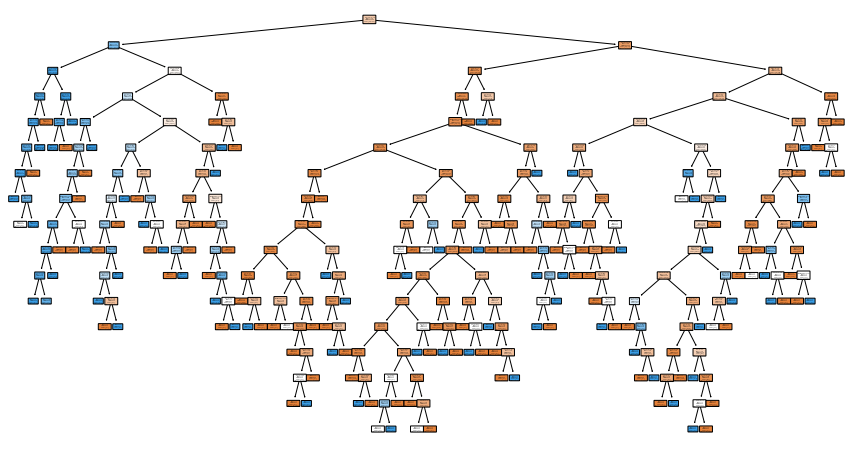

In [18]:
plt.figure(figsize=(15,8))
plot_tree(  clf_dt,
            filled = True,
            rounded = True,
            class_names = ["Didn't Survive", "Survived"],
            feature_names=X.columns)
plt.show()

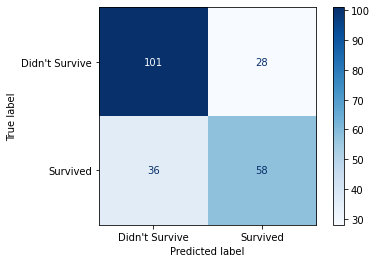

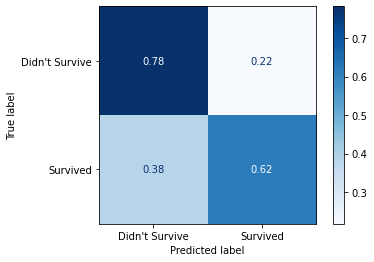

In [19]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    plot_confusion_matrix(  clf_dt,X_test,Y_test,
                            display_labels=["Didn't Survive","Survived"],
                            normalize=normalize,
                            cmap=plt.cm.Blues,)

# Cost Complexity Pruning: Visualize Alpha

In [20]:
path = clf_dt.cost_complexity_pruning_path(X_train,Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=random_state_number,ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train,Y_train)
    clf_dts.append(clf_dt)

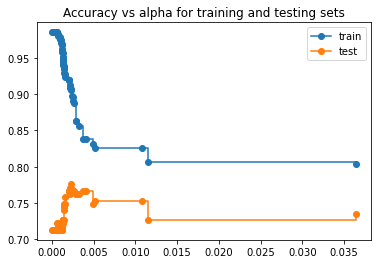

In [21]:
train_scores = [clf_dt.score(X_train,Y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,Y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel = ("alpha")
ax.set_ylabel = ("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores,marker='o',label="train",drawstyle="steps-post")
ax.plot(ccp_alphas,test_scores,marker='o',label="test",drawstyle="steps-post")
ax.legend()
plt.show()

# Cost Complexity Pruning: Cross Validation For Finding the Best Alpha

&lt;AxesSubplot:xlabel=&#39;tree&#39;&gt;

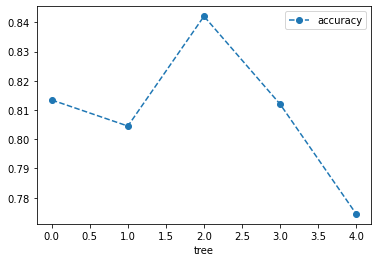

In [22]:
clf_dt = DecisionTreeClassifier(random_state=random_state_number,ccp_alpha=0.004)

scores = cross_val_score(clf_dt,X_train,Y_train,cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree',y='accuracy', marker='o', linestyle='--')

&lt;AxesSubplot:xlabel=&#39;alpha&#39;&gt;

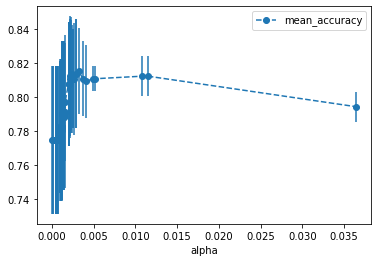

In [23]:
alpha_loop_values=[]

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=random_state_number,ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt,X_train,Y_train,cv=5)
    alpha_loop_values.append([ccp_alpha,np.mean(scores),np.std(scores)])

alpha_results = pd.DataFrame(   alpha_loop_values,
                                columns = ['alpha','mean_accuracy','std'])

alpha_results.plot( x='alpha',
                    y='mean_accuracy',
                    yerr='std',
                    marker='o',
                    linestyle='--')

In [24]:
alpha_results[  (alpha_results['alpha']>0.002) & 
                (alpha_results['alpha']<0.005)]

,alpha,mean_accuracy,std
40,0.002002,0.807799,0.036441
41,0.002002,0.807799,0.036441
42,0.002002,0.807799,0.036441
43,0.002147,0.810807,0.035090
44,0.002154,0.812299,0.035328
45,0.002252,0.813803,0.033475
46,0.002329,0.812311,0.033292
47,0.002433,0.810807,0.031704
48,0.002503,0.810818,0.029027
49,0.002510,0.810818,0.029027


In [25]:
ideal_ccp_alpha = 0.003862

# Building ideal classification tree

In [26]:
clf_dt_final = DecisionTreeClassifier(ccp_alpha=ideal_ccp_alpha,random_state=random_state_number)
clf_dt_final = clf_dt_final.fit(X_train,Y_train)

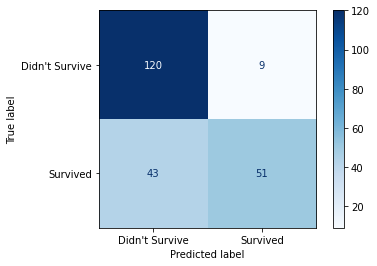

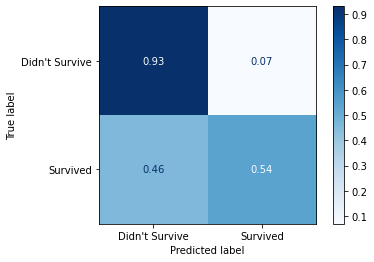

In [27]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    plot_confusion_matrix(  clf_dt_final,X_test,Y_test,
                            display_labels=["Didn't Survive","Survived"],
                            normalize=normalize,
                            cmap=plt.cm.Blues,)

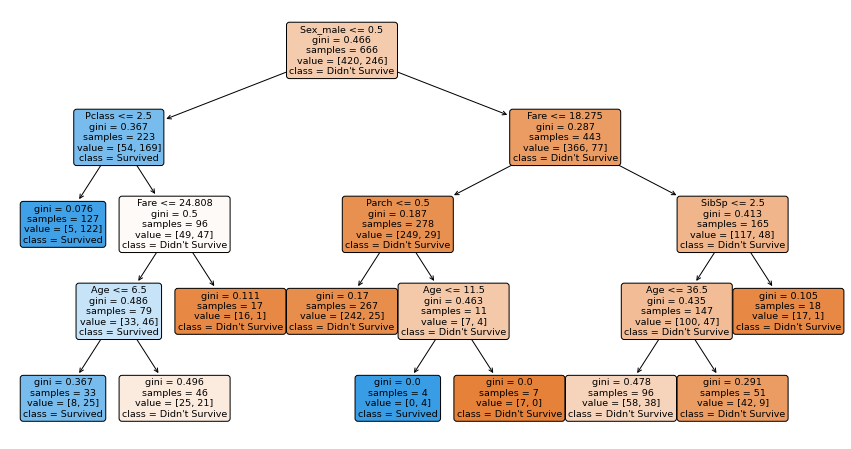

In [28]:
plt.figure(figsize=(15,8))
plot_tree(  clf_dt_final,
            filled = True,
            rounded = True,
            class_names = ["Didn't Survive", "Survived"],
            feature_names=X.columns)
plt.show()

# Submit Predictions

In [29]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34,0,0,7.8292,0,1,0,1,0
1,893,3,47,1,0,7.0000,1,0,0,0,1
2,894,2,62,0,0,9.6875,0,1,0,1,0
3,895,3,27,0,0,8.6625,0,1,0,0,1
4,896,3,22,1,1,12.2875,1,0,0,0,1


In [30]:
X_test  = test.drop("PassengerId", axis=1).copy()
Y_pred = clf_dt_final.predict(X_test)

In [31]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)

In [32]:
submission = pd.read_csv('submission.csv')
submission.Survived.mean() # 0.383838 in train

0.2679425837320574

In [33]:
from checkAccuracy import accuracy

0.7642857142857142
